# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
%matplotlib inline

from structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
import math

## Load in our data from the previous Notebook

In [4]:
PATH = "data"

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [5]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [6]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [7]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1248307200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,9.259131,1840702,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401121,6333337,9.305651,1830472,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401122,6333338,9.350102,1887659,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401123,6333341,9.104980,1903570,21435,149,2.0,2005,NaN,NaN,30NX,...,25,1,298,False,False,False,False,False,False,1319500800


In [8]:
set_rf_samples(50000)

In [11]:
m = RandomForestRegressor(n_estimators=150, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2033968102713607, 0.24563845989609168, 0.9135384330744893, 0.8922441875926709, 0.8969348506246859]


# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [12]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.175508
37,Coupler_System,0.111654
13,ProductSize,0.100041
14,fiProductClassDesc,0.083123
2,ModelID,0.058654
63,saleElapsed,0.051105
39,Hydraulics_Flow,0.044637
10,fiSecondaryDesc,0.042408
19,Enclosure,0.035861
38,Grouser_Tracks,0.035662


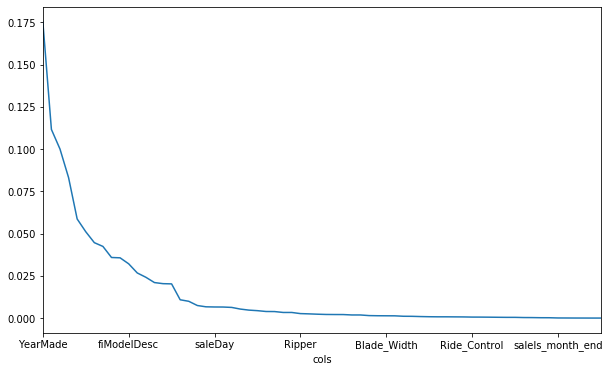

In [13]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [14]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

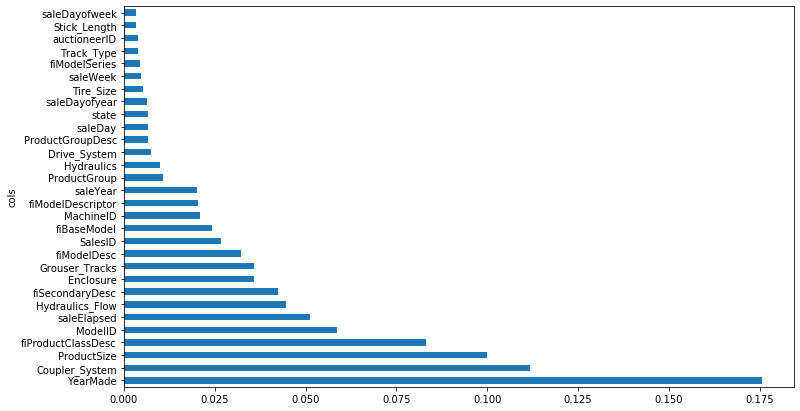

In [15]:
plot_fi(fi[:30]);

In [16]:
to_keep = fi[fi.imp>0.03].cols; len(to_keep)

11

In [17]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [19]:
m = RandomForestRegressor(n_estimators=150, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2116338938085293, 0.23720818371850447, 0.9063936586188011, 0.8995135947339882, 0.895597967703104]


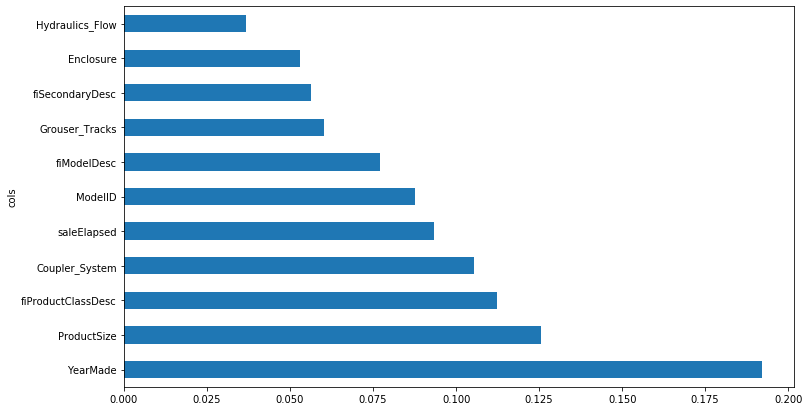

In [20]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## One-hot encoding

proc_df's optional *max_n_cat* argument will turn some categorical variables into new columns.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [21]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=150, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20538724247659693, 0.2515690953563195, 0.9118379349352057, 0.8869781140094004, 0.894858331227572]


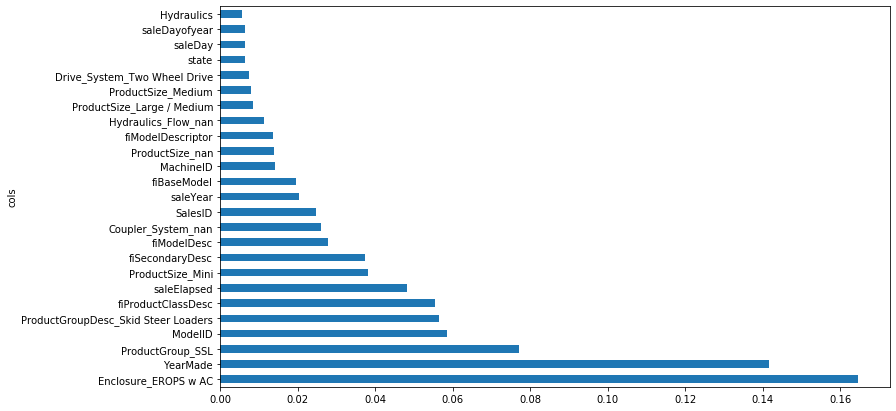

In [22]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [23]:
from scipy.cluster import hierarchy as hc

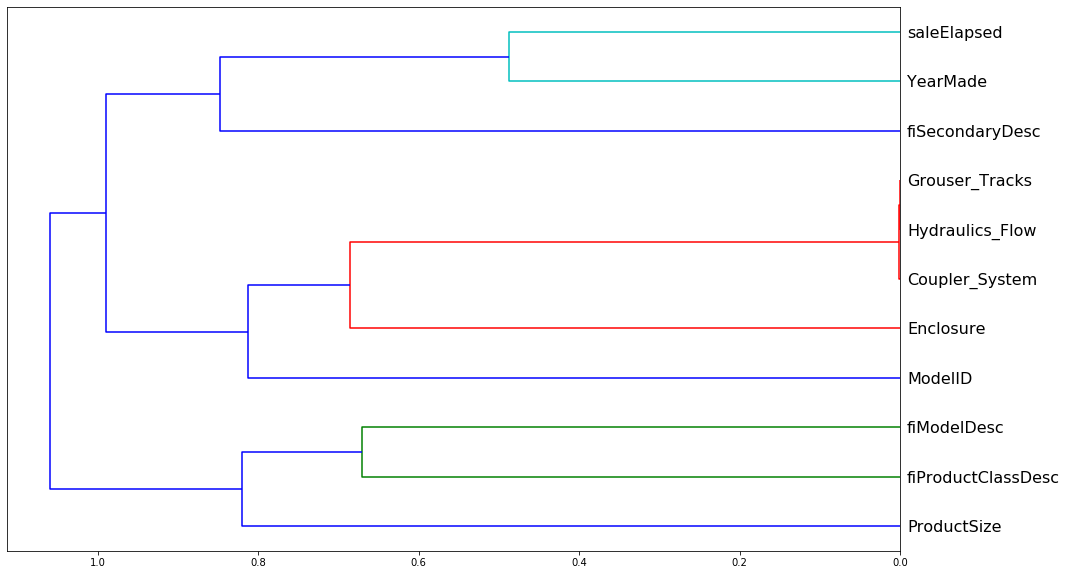

In [25]:
import scipy
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [26]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=150, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [27]:
get_oob(df_keep)

0.8917682323529754

Now we try removing each variable one at a time.

In [31]:
for c in ( 'saleElapsed', 'fiModelDesc', 'Coupler_System','Grouser_Tracks','Hydraulics_Flow'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleElapsed 0.803590366107749
fiModelDesc 0.8881378843298872
Coupler_System 0.8922142525437852
Grouser_Tracks 0.8923322895880554
Hydraulics_Flow 0.8923366426154214


We can try removing Coupler systems,Grouser_Tracks,Hydraulics_Flow. Let's see what that does.

In [37]:
to_drop = ['Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8922979856466281

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [38]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [39]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

And let's see how this model looks on the full dataset.

In [40]:
reset_rf_samples()

In [42]:
m = RandomForestRegressor(n_estimators=160, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.15773204232596477, 0.22140169625692505, 0.9480034319883471, 0.9124593308979757, 0.9084384300074688]


The root mean square logarithmic error achieved here on the validation set is 0.2214 which when compared to the leaderboard here(https://www.kaggle.com/c/bluebook-for-bulldozers/leaderboard) is Ranked No 2 out of 475 teams 